<a href="https://colab.research.google.com/github/Eduardo-Mati/Projetos-integrador---Desafio-unifacisa---Modelos-de-Machine-Learning/blob/main/Q9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [2]:
# --- Bibliotecas para Manipulação e Análise de Dados ---
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os




In [3]:
# --- 1. Definindo as Configurações e Caminhos ---

# Definição das dimensões da imagem e número de classes
IMG_WIDTH, IMG_HEIGHT = 150, 150
NUM_CLASSES = 2 # Normal e Pneumonia

# Caminhos para os diretórios (verifique se estão corretos para o seu ambiente)
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# --- 2. Correção do Desbalanceamento de Classes ---

# Contando o número de imagens em cada classe para calcular os pesos
normal_cases = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia_cases = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
total_samples = normal_cases + pneumonia_cases

print(f"Casos Normais no Treino: {normal_cases}")
print(f"Casos de Pneumonia no Treino: {pneumonia_cases}\n")

# Calculando os pesos para dar mais importância à classe com menos amostras
weight_for_0 = (1 / normal_cases) * (total_samples / 2.0)
weight_for_1 = (1 / pneumonia_cases) * (total_samples / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Peso para a classe Normal (0): {class_weights[0]:.2f}")
print(f"Peso para a classe Pneumonia (1): {class_weights[1]:.2f}\n")

Casos Normais no Treino: 1341
Casos de Pneumonia no Treino: 3875

Peso para a classe Normal (0): 1.94
Peso para a classe Pneumonia (1): 0.67



In [5]:
# --- 3. Construindo o Modelo (Simplificado e Regularizado) ---

model = Sequential([
    # Primeira camada convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),  # Adicionado para estabilizar o treinamento
    MaxPooling2D(pool_size=(2, 2)),

    # Segunda camada convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Terceira camada convolucional
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Achatar os resultados
    Flatten(),

    # Camada densa (REDUZIDA) para diminuir o overfitting
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Camada de saída
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# --- 4. Compilando o Modelo (com Taxa de Aprendizado Reduzida) ---

# Usando o otimizador Adam com uma taxa de aprendizado menor para um ajuste mais fino
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,609 (36.49 MB)

 Trainable params: 9,564,161 (36.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
# --- 5. Preparando os Geradores de Dados ---

# Criando geradores de dados com augmentation para o treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Para o conjunto de teste e validação, apenas redimensionamos (sem augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Carregando as imagens dos diretórios
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
# --- 6. Treinando o Modelo ---

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    class_weight=class_weights  # <-- APLICANDO OS PESOS PARA CORRIGIR O DESBALANCEAMENTO
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 610ms/step - accuracy: 0.8084 - loss: 0.7062 - val_accuracy: 0.5000 - val_loss: 7.0176
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 428ms/step - accuracy: 0.8747 - loss: 0.3018 - val_accuracy: 0.5000 - val_loss: 16.3336
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 429ms/step - accuracy: 0.8818 - loss: 0.2981 - val_accuracy: 0.5000 - val_loss: 6.6936
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 442ms/step - accuracy: 0.8827 - loss: 0.2509 - val_accuracy: 0.8125 - val_loss: 0.7087
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 429ms/step - accuracy: 0.9031 - loss: 0.2432 - val_accuracy: 0.6875 - val_loss: 0.4810
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 433ms/step - accuracy: 0.8993 - loss: 0.2322 - val_accuracy: 0.6875 - val_loss: 0.7006
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 429ms/step - accuracy: 0.9067 - loss: 0.2500 - val_accuracy: 0.8750 - val_loss: 0.4169
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 426ms/step - accuracy: 0.9089 - loss:

Found 624 images belonging to 2 classes.
624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step

# Relatório de Classificação #
              precision    recall  f1-score   support

      NORMAL       0.66      0.94      0.77       234
   PNEUMONIA       0.95      0.71      0.81       390

    accuracy                           0.79       624
   macro avg       0.80      0.82      0.79       624
weighted avg       0.84      0.79      0.80       624


# Matriz de Confusão #


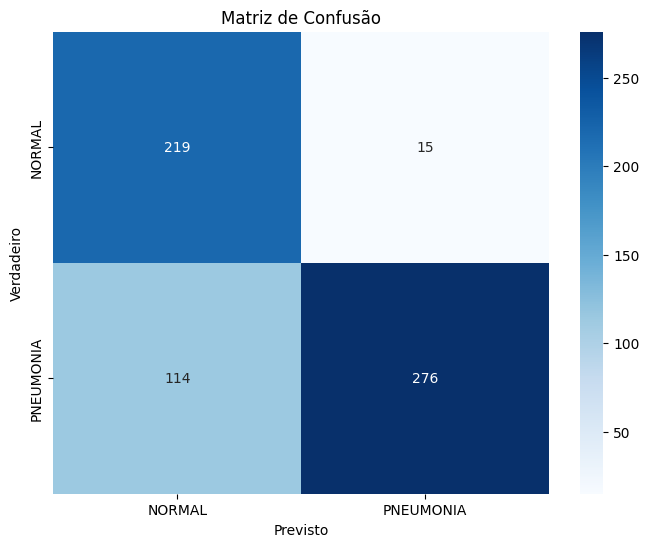

In [9]:
# --- 7. Avaliando o Modelo ---

# Preparando o gerador de teste (importante não embaralhar para a matriz de confusão)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,        # Batch size de 1 para prever imagem por imagem
    shuffle=False,       # NUNCA embaralhe os dados de teste na avaliação
    class_mode='binary'
)

# Fazendo predições no conjunto de teste
predictions = model.predict(test_generator, steps=len(test_generator))
# Usando o limiar padrão de 0.5 para classificar como 0 ou 1
predicted_classes = (predictions > 0.5).astype(int)

# Obtendo as classes verdadeiras e os rótulos
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Relatório de classificação (precisão, recall, etc.)
print("\n# Relatório de Classificação #")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Matriz de Confusão
print("\n# Matriz de Confusão #")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()
